# Use to run models for pv detection


Modules

In [6]:
import pandas as pd
import numpy as np

from pandas import json_normalize
import json
from skimage.draw import polygon, polygon_perimeter
from skimage import measure
from skimage import io

from matplotlib.patches import Circle, Polygon
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns

import os
import dotenv

from roboflow import Roboflow 

import torch.nn as nn 
import torch
import pytorch_lightning as pl
import image_recongnition 

import os
import sys

from pycocotools.coco import COCO

current_directory = os.getcwd()
script_dir = os.path.dirname(current_directory + 'models')  
base_cnn_dir = os.path.join(script_dir, 'architectures')  
sys.path.append(base_cnn_dir)

Load Data from Roboflow

In [4]:
# Load data from roboflow 
%cd C:\Users\20193362\Desktop\InterProject\InterdisciplinaryProject\data
dotenv.load_dotenv()
DATASET_KEY = os.getenv('API_KEY')
if not os.path.exists(r'NL-Solar-Panel-Seg-1'):
    rf = Roboflow(api_key=DATASET_KEY)
    project = rf.workspace("electasolar").project("nl-solar-panel-seg")
    version = project.version(1)
    dataset = version.download("coco-segmentation")

C:\Users\20193362\Desktop\InterProject\InterdisciplinaryProject\data
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to NL-Solar-Panel-Seg-1 in coco-segmentation:: 100%|██████████| 39810/39810 [01:53<00:00, 350.68it/s]


Define Dataloaders

Visualize Images


loading annotations into memory...
Done (t=0.60s)
creating index...
index created!


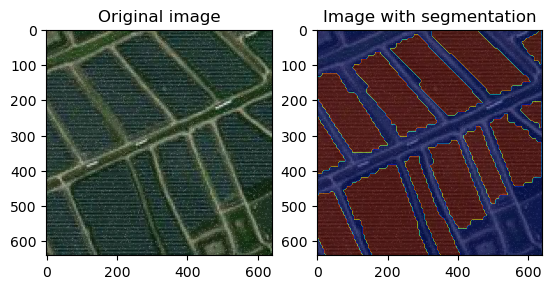

In [9]:
# Paths
coco_json_path = 'C:/Users/20193362/Desktop/InterProject/InterdisciplinaryProject/data/NL-Solar-Panel-Seg-1/train/_annotations.coco.json'
image_directory = 'C:/Users/20193362/Desktop/InterProject/InterdisciplinaryProject/data/NL-Solar-Panel-Seg-1/train'

# Initialize COCO
coco = COCO(coco_json_path)

# Get ids of images in the dataset
image_ids = coco.getImgIds()
image_data = coco.loadImgs(image_ids[0])[0] # Choose first one

# Load image
image_path = os.path.join(image_directory, image_data['file_name'])
image = io.imread(image_path)

# Load annotations for image
annIds = coco.getAnnIds(imgIds=image_data['id'])
anns = coco.loadAnns(annIds)

# Initialize empty mask
combined_mask = np.zeros_like(image[:, :, 0])

# Add all segmentations
for ann in anns:
    mask = coco.annToMask(ann)  # Get the binary mask for this annotation
    combined_mask += mask  # Add mask to the combined mask
combined_mask = np.minimum(combined_mask, 1) # Make it binary

# Display image
plt.figure()
# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original image')

# Image with segmentation 
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.imshow(combined_mask, cmap='jet', alpha=0.5)  # Transparancy
plt.title('Image with segmentation')

plt.show()

Load model 

In [19]:

from base_cnn import ImageRecognitionModel 
from image_recongnition import BaseModel

model = ImageRecognitionModel(hidden_size=32, num_classes=10)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)
metrics = {"accuracy": nn.CrossEntropyLoss()}
model = BaseModel(model, loss_fn, optimizer, scheduler, metrics)

trainer = pl.Trainer(max_epochs=10)

trainer.fit(model, train_loader, val_loader)





GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


NameError: name 'train_loader' is not defined